# Heated Pipe System with Heat Loss

This tutorial describes the process of controlling the outlet temperature of a 300 meters heat pipe close to the 
boiling temperature.

The main goal is to describe the process of solving rather than the details of the equations.

---
## 1. System Description

The system consists of a 300m circular pipe through which water flows continuously. A heater is connected at the entrance ($x = 0$) 
of the pipe, providing a constant power input $P$ to the water. The water flows with constant velocity $u$, losing heat 
to the environment due to convection. At the outlet, the water returns to the heater, creating a closed loop.

![heat loop](images/simple_diagram.png)

The goal is to perform a bacteria decontamination of the loop, requiring a temperature of at least 85°C through the loop
with a 2°C/min ascent and without creating steam in the pipe.

***How to ensure $T_{outlet}$>85°C and $T_{inlet}$<95°C ? Can we control the heating speed precisely to 2°C/min?***

### First findings, why is it tricky?

Following plot shows what happens when the system is heated at a constant 30kW power which is barely the maximum power :

![heat loop](images/initial_problem.png)

From this we observe :
- Stair-like behavior due to the recirculation of water
- An inlet temperature that can go close to 100°C despite an outlet temperature that is barely above 85°C
- A significant delay (~12 min)
- A coupling and an intrication between inlet and outlet temperature
- A single test is about 3 hours to consider rising time
- **Perfomances** are defined on outlet temperature
- **Security** is defined on inlet temperature

**How to model and simulate these stairs and avoid testing on the real system?**

### Naive model

[//]: # (The PDE equation can be naively discretized as follows:)

[//]: # (- The pipe is divided in N discrete segments)

[//]: # (- For each segment, its temperature is obtained by averaging its temperature with the neighbors and with the surrounding )

[//]: # (environment,subject to the heat loss coefficient.)

[//]: # (- Each temperature value is transferred to the next segment)

Following simulation divides the pipe into small segments to model heat transfer step by step. At each time step, every segment’s 
temperature is updated based on its neighbors and the environment (using a heat loss coefficient), while the temperature at the pipe’s end is "pushed forward" 
to the start—like a wave of heat moving through. The heater at one end injects warmth, and the animation reveals how heat spreads, 
stabilizes, and flows through the system.

![heat loop](images/pipe_simulation.gif)

This gives a first approximation and intuition on the system to explain the stairs and the impact of losses on the heating curve.

Detailed plots in Appendix show the impact of heat loss coefficient and external temperature on the curves.

## Physical model equations:

The system schematic is shown below:

![heat loop](images/heat_loop.png)

The evolution of the temperature in the pipe is governed by the following partial differential equation (PDE) obtained by 
writing the energy balance equation of a pipe infinitesimal segment:

$$
\frac{\partial T}{\partial t} + u \frac{\partial T}{\partial x} = -\frac{h P_{\text{pipe}}}{\rho S c_p} \left[ T(x, t) - T_{\text{ext}} \right]
$$

All notations are detailed in Appendix.

To include the heater power in the equations, we can write the energy balance of the heater using 
$ \Theta_{\text{inlet}}(t) = T_{\text{inlet}} - T_{\text{ext}} $ and $\Theta_{\text{outlet}}(t) = T_{\text{outlet}} - T_{\text{ext}}$.
This allows to write the following Delayed Equations in which $\tau$ is the time of travel, $P$ the power of the heater, and $K<1$ the loss coefficient:

$$
\Theta_{\text{inlet}}(t) = \frac{P}{\dot{m}c_p} + K \Theta_{\text{inlet}}(t - \tau),
\Theta_{\text{outlet}}(t) = K \left( \frac{P}{\dot{m} c_p} +  \Theta_{\text{outlet}}(t - \tau) \right).
$$

What these equations say :
- A pipe segment always sees the water from one turn past, which temperature is modulated by the losses
- From an energy point of view, the system adds to the loop the amount of energy contained by the water inside the heater 
- Effect of the power is inversely scaled by the flow $\dot{m}$ which directly affects system properties



## 2. System Simulation

Following example show the step response of the system for a given power input :

In [3]:
from simulation_backend import *
from ipywidgets import interact, FloatSlider, fixed
interact(
    simulate_and_plot,
    P=FloatSlider(min=1, max=33, step=0.5, value=10, description='Power (kW):'),
    T_ext=FloatSlider(min=0, max=40, step=0.5, value=10, description='External temperature (°C):')
);

interactive(children=(FloatSlider(value=10.0, description='Power (kW):', max=33.0, min=1.0, step=0.5), Output(…


## 3. Control

### Control Objectives

Our system should respect the following goals:


### 1) Traditionnal SISO control technique, with tinkering

The standard equation of the PI controller is:

$$
u(t) = K_p \, e(t) + K_i \int_0^t e(\tau) \, d\tau,
$$

where:
- u(t) is the power of the heater,
- $K_p$ is the proportional gain,
- $K_i$ is the integral gain,
- e(t) is the error between the setpoint and the outlet temperature.


This is a Single Input - Single Output (SISO) controller
First simulation show the result with a P controller only. 
It exhibits the need to continuously add energy to the system to compensate for the losses, hence a nonzero $K_i$ :


In [4]:
from PI_backend import *

# Interactive sliders for tuning Kp, Ki, and T_ext
interact(
    simulate_PI,
    Kp=FloatSlider(min=0, max=2000, step=50, value=1500, description="Kp [W/°C]"),
    Ki=FloatSlider(min=0, max=0.5, step=0.025
                   , value=0.01, description="Ki [W/(°C·s)]"),
    T_ext=FloatSlider(min=0, max=40, step=1, value=20, description="T_ext (°C)"),
    T_set=fixed(85.0),
    save_csv = fixed(False),
    ramped = fixed(False),
    csv_filename = fixed(""),
    alpha = fixed(10.0),
);

interactive(children=(FloatSlider(value=1500.0, description='Kp [W/°C]', max=2000.0, step=50.0), FloatSlider(v…

With correct tuning of the coefficients, we obtain following behavior :

Saved PI simulation results to results/PI_run_data.csv


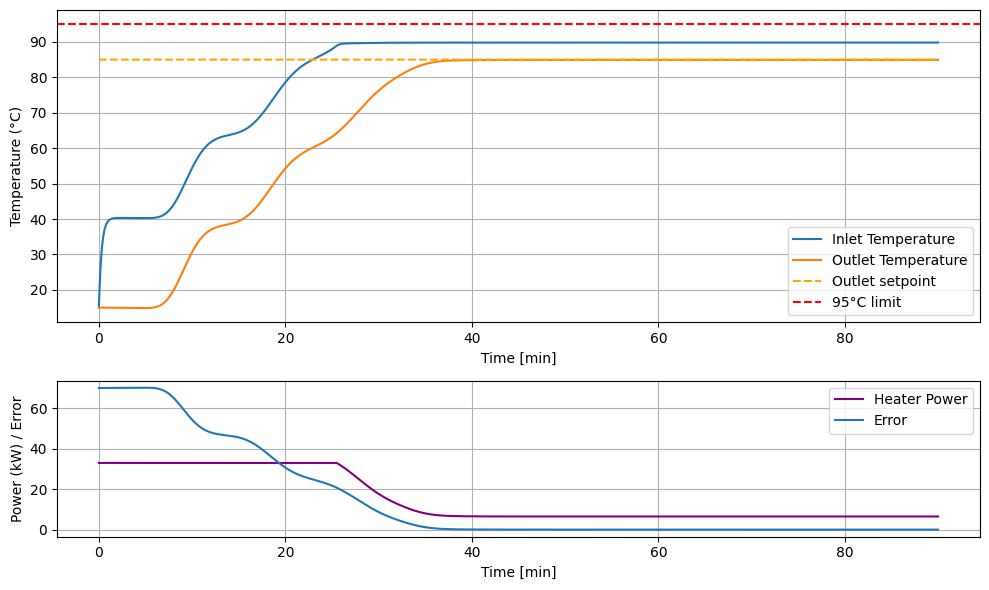

In [5]:
simulate_PI(Kp=1300,Ki=0.08,T_ext=10,save_csv=True, ramped = False, csv_filename="results/PI_run_data.csv", T_set = 85);

**How to enforce constraint handling on such a controller?** 

PI controllers have no direct way to ensure constraints, especially when the constraint is set on another variable.
To overcome this issue, we propose a gain scheduling technique based on the inlet temperature.
To ensure security on inlet temperature, the gains $K$ are modified dynamically based on $T_{\text{inlet}}$ as follows:
$$
K = K_{\text{initial}} \left( 1 - e^{-\alpha |T_{\text{inlet}} - T_{max}|} \right),
and ~K=0~ if ~T_{inlet}>T_{max}
$$
where:
- $K_{\text{initial}}$ is the initial  gain,
- $\alpha$ is a tuning parameter controlling the rate of gain reduction,
- $T_{max}=95°C$ is the limit temperature 

This ensures that the system is maintaining security requirements in a soft linear manner, while tracking the reference of outlet temperature. 



### 2) Optimal control via MPC, SIMO control fashion

Since we have access to a model, we can explore optimal control via Model Predictive Control (MPC). 
MPC leverages the model to find the best input to the system based on a horizon prediction ($N_p$).
It strength is to be able to consider both states for a single input to the system.
At each timestep, MPC controller computes the best input sequence for the future, apply the first one, and repeat the process to ensure good predictions and response to uncertainties.
![MPC](images/MPC_principle.png)
[source : ETH]

To do so, MPC uses weights to formulate the control objective and respect constraints in the optimization process.
MPC formulation of the problem is as follows:

$$
u^*(k) = \min_{u(0), \dots, u(N_p-1)}
\sum_{i=0}^{N_p-1} \left( y_i - (T_{set,i} - d_i) \right)^T Q \left( y_i - (T_{set,i} - d_i) \right) + u_i^T R u_i + \Delta u_i^T S \Delta u_i,
$$
$$
\text{subject to:}
\begin{align*}
&\mathbf{x}(0) = \mathbf{x}_0\\
&\mathbf{x}_{i+1} = A \mathbf{x}_i + B u_i,~y_i = C \mathbf{x}_i \quad i = 0, \dots, N_p-1, \\
&0 \leq x_i=T_{inlet,i},T_{outlet,i} \leq 95, \quad i = 1, \dots, N_p, \\
&0 \leq u_i=P_i \leq 33, \quad i = 0, \dots, N_p-1, \\
&Q \succ 0, \, R \succ 0.
\end{align*}
$$

[//]: # (&\Delta u_i = u&#40;i&#41; - u&#40;i-1&#41;, \quad i = 1, \dots, N_p-1, \\)

where:
- $x = (T_{inlet},T_{outlet} )$ is the state
- $N_p$ is the prediction horizon.
- $T_{set,i}$ is the moving reference at time $i$.
- $d_i$ is the moving disturbance ($T_{ext}$) at time $i$.
- $Q \succ 0$ and $R \succ 0$ are weighting matrices for output tracking and input usage, respectively.

**Is MPC tractable on this problem?** Think about the problem size ...

This approach can be solved using Quadratic Programming (QP) formulation. 
However, to employ this technique, difficulty lies in the fact that :
1) The model is high order, $x$ is (1,30) for a  30 segment pipe discretization.
2) Horizon to control $T_{outlet}$ should be 600, which implies dealing with huge matrices.

For each issue :
- 1 $N$ is set to 20 to lighten the simulation, and could be tackled by using simplified models for $T_{inlet}$ and $T_{outlet}$ respectively
- 2 is tackled by setting the controller frequency to 0.1Hz, meaning one step is 10s, and setting the horizon to 70 steps, i.e. 700s

Moreover, a secondary objective is set on $T_{inlet}=92°C$ to incentive the controller to use both sensors.


In [ ]:
from ipywidgets import interact, FloatSlider, IntSlider
from MPCRun import run_MPC

run_MPC(Hp=80, Q=[0.0, 1e3], R=1e-5, Rd=1.0, T_set=[92.0, 85.0], T_safety=95.0, ramped = False)


![MPC_main_results](images/MPC_main_results_2.png)
![heat loop](images/MPC_results_input_2.png)

From this, we can observe a much more complex behavior than the PI controller which was bounded to its linear behavior. Time of heating is reduced by .. min because the controller can leverage the full power before decreasing.
A small error remains, indicating a better tuning could be performed.

This formulation is way more flexible and allows to control each temperature with the same controller.

### 3) Reinforcement Learning

Reinforcement Learning (RL) uses a generic formulation of the control problem as an environment to which is inputted an action and which outputs an observation and a reward.
RL algorithms uses the reward to learn a policy $\pi(state)=action$. The goal of the learning process is to make this policy converging towards an optimal policy *\pi^*$ i.e. the one that maximizes the cumulative reward on an episode.

![RL](images/Reinforcement_learning_diagram.svg)

We define our environment as follows using our simulation :

**Action**

At each timestep, the agent selects a continuous action
$$
a \in [0, 33] kW,
$$
which corresponds to the heater power in kilowatts.  

**State (Observation)**

The observation provided to the agent is a vector of five components:
$$
obs = \big(T_{\text{inlet}},\; T_{\text{outlet}},\; T_{\text{sp}},\; T_{\text{sp}} - T_{\text{outlet}},\; T_{\text{safety}} - T_{\text{inlet}}\big),
$$
**Note 1** : these are a bit redundant and are used for simulation simplicity, for a more general case, $T_{ext}$ should also be included to allow the agent to react to fast temperature changes from the environment. 

**Note 2** : For control, relative observation allows to make the developed policy independant of the setpoint value. 

**Reward**

The reward balances setpoint tracking, smooth control, energy usage, and safety:
$$
r = -\lvert T_{\text{sp}} - T_{\text{out}} \rvert
    - \lambda_{\Delta P}\,|P - P_{\text{prev}}|
    + \lambda_P P
    + r_{\text{safety}}.
$$

- $-\lvert T_{\text{sp}} - T_{\text{out}} \rvert$: directly penalizes deviation from the outlet setpoint,
- $-\lambda_{\Delta P}\,|P - P_{\text{prev}}|$: penalizes fast changes in heater power and incentive constant power,
- $\lambda_P P$: small incentive for using heater power, this helps to explore despite large delay,
- $r_{\text{safety}} = -10$ if $T_1 > T_{\text{safety}}$, otherwise $0$.

**Algorithm**

Soft Actor-Critic (SAC) is chosen for its good versatility and performances.

**Results**

To prevent noisy outputs from the RL controller, actions are filteredd with an average filter ($\alpha=0.2$) giving :

![filtRL](images/filtered_RL_results.png)

This problem could also be solved by discretizing the output of the RL controller, allowing for 0.5 kW steps only (for example).
Despite filtering, RL controller fails tracking precisely the target temperature with precision.


## Comparison and conclusion

We compare and discuss the 3 methods based on:
- Their performances on setpoint tracking
- The compliance with the security criterion on inlet temperature
- Their complexity of validation and integration

### Performances : Constant setpoint tracking

On the task of tracking a constant outlet temperature, all the controllers achieve similar performances. This is due to :
- The saturation of the input between 0 and 25 min approximately
- 

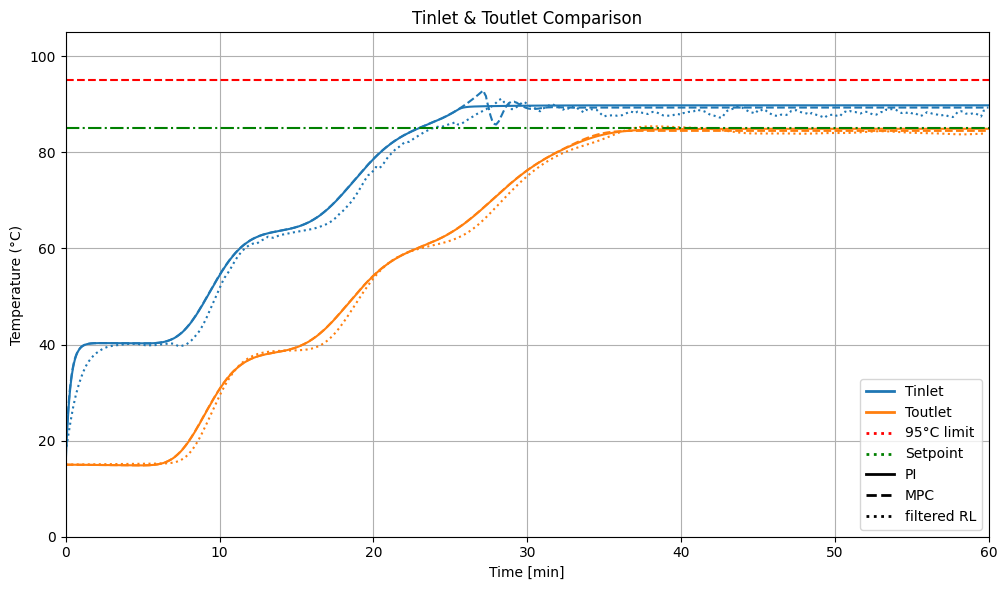

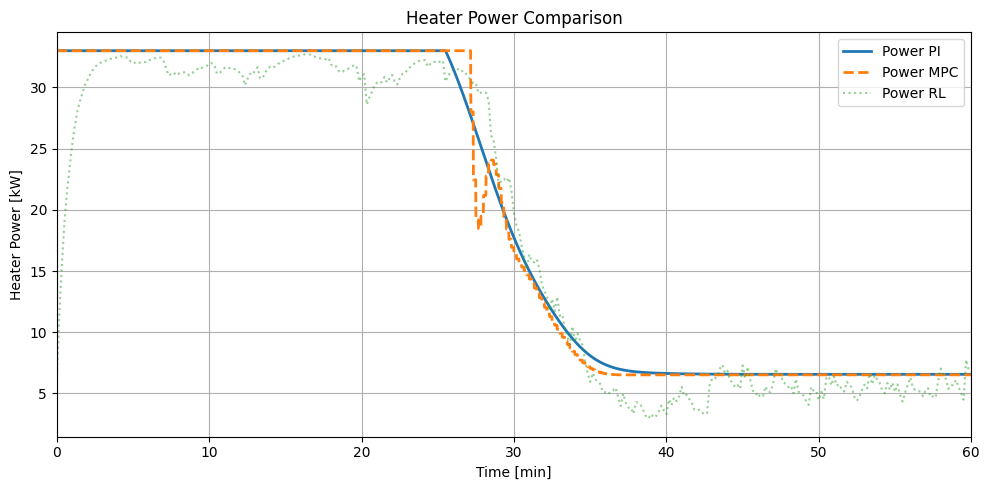

In [1]:
from compare_everything import plot_comparison_step

plot_comparison_step()

To discriminate their capabilities, we can compare them on the tracking of a ramped temperature of 2°/min with a saturation at 85°C.
The PI controller can be fine-tuned to track the reference:

**Warning, this example is a bit tricky because the PI controller has no information about the delay, the fact it is able to track it accordingly is due to a specific tuning, to use a PI controller properly on this system, a delay compensator should be integrated**

Saved PI simulation results to results/ramp_PI_run_data.csv


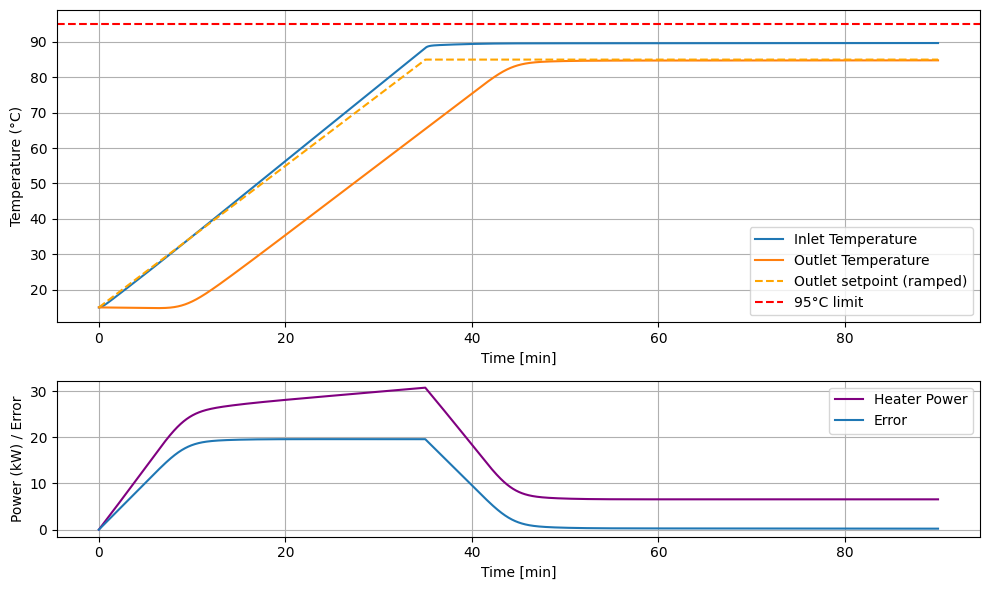

In [8]:
simulate_PI(Kp=1300, Ki=0.15, T_ext=10, save_csv=True, ramped = True, csv_filename="results/ramp_PI_run_data.csv");

MPC and RL are run on the ramp reference with same tuning as before.
Comparison is given below :

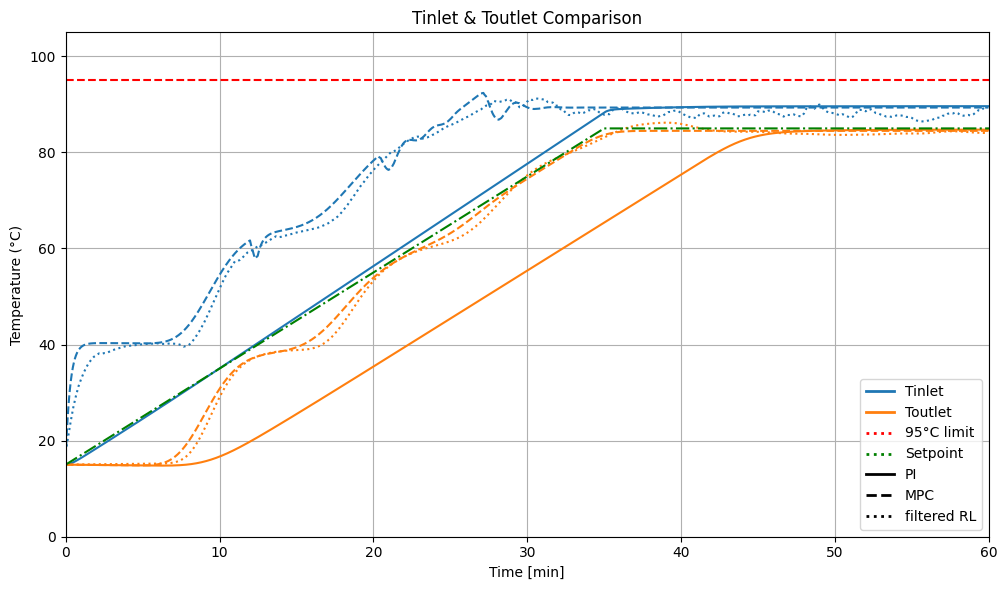

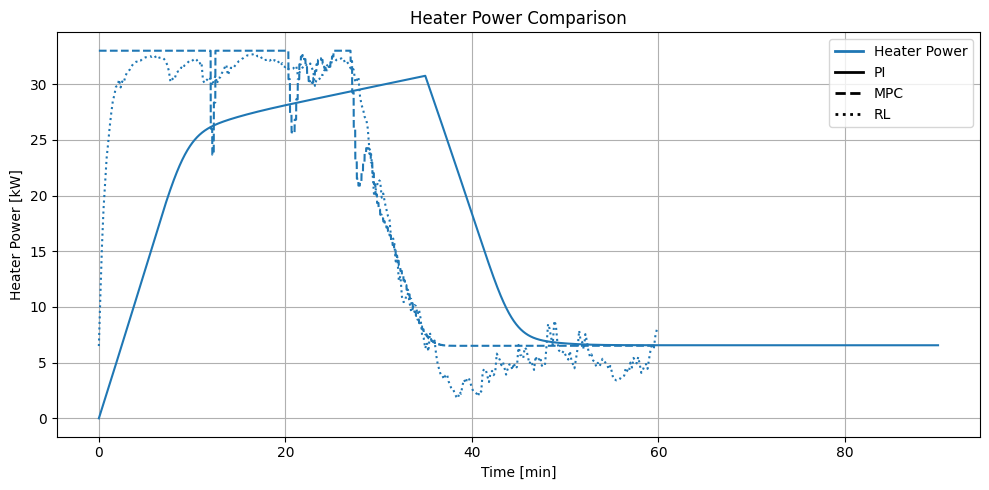

In [2]:
from compare_everything import plot_comparison_ramp

plot_comparison_ramp()

The MPC controller can track the reference without fine-tuning, as it can predict to use a given input for its future output.
RL has not been trained on the ramp following and exhibits its limitation on out-of-distribution example, meaning the training was not good enough for the controller to generalize.


### Security

The system we studied has some inherent risks which can disturb the controllers, among which :
1. Control instability
2. Boiling water or steam at pipe inlet
2. Rapid change in external temperature
3. Sensor failure

**Stability**

The slow dynamics of the system makes it inherently stable. 
However, trying to heat quicker implies using high gains which could result in instability, for the PI controller this is handled by checking the closed loop stability via Nyquist criterion (See [here](https://en.wikipedia.org/wiki/Nyquist_stability_criterion)) using Bode diagram of the PI controller:

![Bode](images/Bode_PI.png)

Similar reasoning can be performed on the MPC controller using assumptions on cost to conclude on a Lyapunov stability.

RL controller is harder to validate for stability, only multiple simulation on the learned controller can allow to evaluate its stability. On smaller observation space, the policy function could be studied in a bounded space to conclude on system stability using closed loop arguments.

**Boiling water**

The risk of having boiling water or steam in the system is the most dangerous risk of the system which could damage the pipes, or harm an operator. 
To mitigate the risk 
- Gain scheduling based on inlet temperature can be used on PI controllers, the lower $\alpha$ is, the stronger the security is:

In [10]:
from PI_backend import *

# Interactive sliders for tuning Kp, Ki, and T_ext
interact(
    simulate_PI,
    Kp=fixed(1300.0),
    Ki=fixed(0.08),
    T_ext=FloatSlider(min=0, max=40, step=1, value=20, description="T_ext (°C)"),
    T_set=FloatSlider(min=0, max=95, step=1, value=92, description="T_set (°C)"),
    save_csv = fixed(False),
    ramped = fixed(False),
    csv_filename = fixed(""),
    alpha=FloatSlider(min=0.1, max=10, step=0.5, value=8, description="alpha"),
);

interactive(children=(FloatSlider(value=20.0, description='T_ext (°C)', max=40.0, step=1.0), FloatSlider(value…

- MPC controller is inherently respecting constraints, if the optimization process is correctly set up. Meaning it would get as close as possible to unfeasible points.

- RL controller has a dedicated reward to avoid high temperatures but needs to be carefully checked in simulation. Current controller is respecting contraints but fails converging to a different setpoint, meaning the learning process did not generalize properly: 
- 
![security_RL_results](images/security_RL_results.png)


Technically, the difference between inlet and outlet temperatures converges to a fixed value.
Thus, no problem should occur if the outlet setpoint is chosen below a certain max value. 
However, regardless of the chosen method a security mechanism has to be implemented to stop heating if temperature goes above a certain value. 
This can be made via continuous decreasing (equivalent to scheduling) or discrete turn-off.

**Rapid changes in external temperature**

External temperature could be easily included in MPC model or RL observation as a disturbance. 
With this, they could learn to adapt to its variations.

Only the PI controller is blind to the external temperature, however we could draw the bode diagram of $T_{ext}$ -> $T_{outlet}$ to conclude on controller stability, offering a clear definition of the stability domain.

**Sensor failure**

Sensor failure has to be treated with a dedicated algorithm. 
However, since MPC and RL rely on two measurements rather than one, they allow to measure the deviation between their inherent models and the real outputs, which offers a new quantity to monitor to detect sensor failures.


### Complexity, Flexibility and running frequency

**Complexity/Flexibility**

- **PI controller** is very easy to implement and the effect of the tuning of its coefficients is easy to grasp. It could adapt easily to different situations and requirements with dedicated tuning.
- **MPC controller** is harder to implement, even when the model is available, bad tuning can results in non-feasible solutions, and despite long computations it might sometime reach suboptimal solutions. However, it is more flexible to changes in the reference tracking and can be easily adapted to new situations by adding a dedicated cost.
- **RL controller** takes time to train but is very fast at inference. The non continuity of the generated actions makes it non directly usable on real systems. Such algorithms need to be used with safeguards. Nonetheless, if a good simulation of the system is available, without having access to a direct model, RL might be the only algorithm to be able to reach a near-optimal solution. Reward cooking might be a long process, and balancing goals a difficult task.

**Running frequency**
1. PI controller can run at a very high frequency because of its low computational cost, 1 Hz frequency was chosen because the system is naturally slow.
2. MPC requires a lot of computation, which might take more than a second to complete. Moreover, its horizon time is a function of its discretization step. For both reasons, it was run at 0.1 Hz, i.e. every 10s.
3. RL provides very fast inference, which is compatible with a 1 Hz frequency, however for training time reduction, this controller was also trained at 0.1 Hz.

## Conclusion

Following table summarizes some of our discussion:

| Criteria                       | PI (Proportional-Integral)                         | MPC (Model Predictive Control)                 | RL (Reinforcement Learning)                                                                        |
|--------------------------------|----------------------------------------------------|------------------------------------------------|----------------------------------------------------------------------------------------------------|
| Performance on Step            | Excellent with good tuning                         | Very good, with non needed input variations    | Shaky, struggle to maintain constant value                                                         |
| Performance on Ramp            | Requires specific tuning, delay is not compensated | Very good, compensate delay, no specific tuning | Need dedicated training                                                                            |
| Security (safety, constraints) | Done via gain scheduler                            | Inherent                                       | Has to be trained and tested on defined cases                                                      |
| Complexity/Flexibility         | Low, simple to implement and easy to test          | High, requires model and optimization solver   | Can be easy if a good simulation is available. New task requires new reward design and retraining. |
| Running frequency              | 1Hz, instant computation                           | 0.1Hz, optimization takes the order of a second | 1Hz or 0.1Hz, fast inference                                                                       |



**Which one would you have picked on a real system?**

# Appendix

### Parameters

- $x$: Position along the pipe in **meters (m)**.
- $t$: Time in **seconds (s)**.
- $T(x, t)$: Temperature of water at position $x$ and time $t$ in **kelvin (K)**.
- $u$: Fluid velocity in **meters per second (m/s)**.
- $\rho$: Density of water in **kilograms per cubic meter (kg/m³)**.
- $c_p$: Specific heat capacity of water in **joules per kilogram-kelvin (J/(kg·K))**.
- $S$: Cross-sectional area of the pipe in **square meters (m²)**.
- $P_{\text{pipe}}$: Perimeter of the pipe in **meters (m)**.
- $h$: Convective heat transfer coefficient in **watts per square meter-kelvin (W/(m²·K))**.
- $P$: Heater power input in **watts (W)**.
- $K = e^{-\frac{\alpha \tau}{2}}$: A factor representing the effect of time delay and thermal losses (dimensionless).
- $\tau$: Delay time in **seconds (s)**.
- $\alpha$: Heat loss coefficient in **per second (1/s)**.

## Simulation details : Impact of coefficients:

Following plots the impact of heat loss coefficient and external temperature on the curves.

![heat loop](images/param_comparison.png)

## MPC details : Model accuracy

MPC uses a simplified version of the model with 20 pipe segments and a 10s integration steps, this creates discrepancies 
in its prediction, the magnitude of the impact is show below on a 30kW input :

![heat loop](images/MPC_vs_full_model.png)

## Note on code and LLM usage:

This tutorial aims to present and discuss different technique usage. 
Some slackness has sometimes been taken to simplify some aspects, without notification.
The initial project has been made in Matlab, code has been converted to Python partly using LLMs (OpenAI and Mistral)